# GANgster
In this notebook we will try to generate mugshots with our generator

In [1]:
import os
import glob
import json

import torch
from torch import nn

import PIL
import time

import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

In [2]:
image_size = 64
generator_entry = 100

In [3]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("running on GPU")
else:
    device = torch.device("cpu")
    print("running on GPU")

running on GPU


In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)), transforms.Resize((image_size, image_size))]
)

In [5]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, images_folder, transform=None):
        self.df = []
        self.transform = transform
        for filepath in glob.glob(f"{images_folder}/*/*F.png"):
            image = PIL.Image.open(filepath)
            if self.transform is not None:
                image = self.transform(image)
            self.df.append((image, os.path.split(filepath)[1].split(".")[0]))

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        return self.df[index]

In [6]:
train_set = CustomDataset(
    images_folder="../data/sd18/single", transform=transform
)

In [7]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

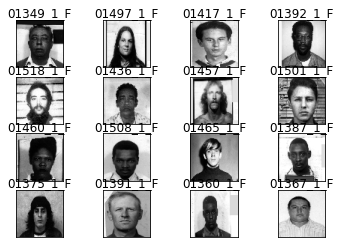

In [8]:
real_samples, real_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    ax.imshow(real_samples[i].reshape(image_size, image_size), cmap="gray")
    ax.set_title(real_labels[i], fontsize=12, pad=1.0)
    ax.set_xticks([])
    ax.set_yticks([])

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(image_size ** 2, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), image_size ** 2)
        output = self.model(x)
        return output

In [10]:
discriminator = Discriminator().to(device=device)

In [11]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(generator_entry, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Linear(2048, image_size ** 2),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, image_size, image_size)
        return output

In [12]:
generator = Generator().to(device=device)

In [13]:
lr = 0.0001
num_epochs = 200000
loss_function = nn.BCELoss()

In [14]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [20]:
per_100_time = []


epoch_start = time.time()
for epoch in range(num_epochs):
    loss_discriminator = 0
    loss_generator = 0
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for training the discriminator
        
        real_samples = real_samples.to(device=device)
        real_samples_size = real_samples.shape[0]

        # Set the labels of the real data to one (Using the size of the real samples array)
        real_samples_labels = torch.ones((real_samples_size, 1)).to(device=device)

        # Set the labels of the fake data to zero
        latent_space_samples = torch.randn((real_samples_size, generator_entry)).to(device=device)
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((real_samples_size, 1)).to(device=device)

        # Concatenate true and fake data
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))
        
        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)

        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels
        )
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((real_samples_size, generator_entry)).to(
            device=device
        )

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

    # Show loss
    if epoch % 100 == 0 and epoch != 0:
        per_100_time.append(time.time() - epoch_start)
        epoch_start = time.time()
        ld = str(round(float(loss_discriminator), 10)).zfill(12)
        lg = str(round(float(loss_generator), 10)).zfill(12)
        it = str(round(per_100_time[-1], 4)).zfill(9)
        av = str(round(sum(per_100_time)/len(per_100_time), 2)).zfill(6)
        seconds = round(
            ((sum(per_100_time)/len(per_100_time)) * ((num_epochs - epoch)/100)),
            2
        )
        m, s = divmod(seconds, 60)
        h, m = divmod(m, 60)
        tl = "%d:%02d:%02d" % (h, m, s)
        print(f"[+] EPOCH : {str(epoch).zfill(7)} | LD.: {ld} | LG.: {lg} | IT : {it}s | AV : {av} | TL : {tl}""")

[+] EPOCH : 0000100 | LD.: 0.0581617095 | LG.: 2.1411802769 | IT : 0010.5466s | AV : 010.55 | TL : 5:51:22
[+] EPOCH : 0000200 | LD.: 0.3502005339 | LG.: 2.1141941547 | IT : 000010.26s | AV : 0010.4 | TL : 5:46:25
[+] EPOCH : 0000300 | LD.: 0.1795596182 | LG.: 2.0399401188 | IT : 0010.5229s | AV : 010.44 | TL : 5:47:34
[+] EPOCH : 0000400 | LD.: 0.0673343912 | LG.: 2.0422029495 | IT : 0010.2594s | AV : 0010.4 | TL : 5:45:52
[+] EPOCH : 0000500 | LD.: 0.3078300655 | LG.: 2.1605007648 | IT : 00010.239s | AV : 010.37 | TL : 5:44:39
[+] EPOCH : 0000600 | LD.: 0.2152889818 | LG.: 2.0834019184 | IT : 0010.2628s | AV : 010.35 | TL : 5:43:54
[+] EPOCH : 0000700 | LD.: 00.185055837 | LG.: 2.0044441223 | IT : 00010.261s | AV : 010.34 | TL : 5:43:19
[+] EPOCH : 0000800 | LD.: 0.4365304112 | LG.: 01.915140748 | IT : 0010.2643s | AV : 010.33 | TL : 5:42:51
[+] EPOCH : 0000900 | LD.: 0.1609087884 | LG.: 2.1758389473 | IT : 0010.2391s | AV : 010.32 | TL : 5:42:21
[+] EPOCH : 0001000 | LD.: 0.44671526

[+] EPOCH : 0007800 | LD.: 00.122594513 | LG.: 2.3183305264 | IT : 0010.0844s | AV : 010.22 | TL : 5:27:31
[+] EPOCH : 0007900 | LD.: 0.4089738429 | LG.: 2.1617805958 | IT : 00010.086s | AV : 010.22 | TL : 5:27:17
[+] EPOCH : 0008000 | LD.: 0.1943537444 | LG.: 2.0820393562 | IT : 0010.0942s | AV : 010.22 | TL : 5:27:04
[+] EPOCH : 0008100 | LD.: 0.4115913212 | LG.: 2.0362896919 | IT : 0010.0685s | AV : 010.22 | TL : 5:26:50
[+] EPOCH : 0008200 | LD.: 0.1689028442 | LG.: 02.244538784 | IT : 0010.0777s | AV : 010.22 | TL : 5:26:37
[+] EPOCH : 0008300 | LD.: 0.3229843378 | LG.: 2.1800522804 | IT : 0010.0785s | AV : 010.22 | TL : 5:26:23
[+] EPOCH : 0008400 | LD.: 0.2530037761 | LG.: 2.3076665401 | IT : 0010.0768s | AV : 010.21 | TL : 5:26:10
[+] EPOCH : 0008500 | LD.: 0.2927528024 | LG.: 2.0705752373 | IT : 00010.079s | AV : 010.21 | TL : 5:25:57
[+] EPOCH : 0008600 | LD.: 0.0577977225 | LG.: 2.1440463066 | IT : 0010.0535s | AV : 010.21 | TL : 5:25:43
[+] EPOCH : 0008700 | LD.: 0.38942325

[+] EPOCH : 0015500 | LD.: 0.3771783412 | LG.: 2.0767986774 | IT : 0010.0597s | AV : 010.15 | TL : 5:11:57
[+] EPOCH : 0015600 | LD.: 0.0657375082 | LG.: 2.2594015598 | IT : 0010.0522s | AV : 010.14 | TL : 5:11:46
[+] EPOCH : 0015700 | LD.: 0.2295056432 | LG.: 02.200555563 | IT : 0010.0514s | AV : 010.14 | TL : 5:11:35
[+] EPOCH : 0015800 | LD.: 0.1859166771 | LG.: 2.1261849403 | IT : 0010.0526s | AV : 010.14 | TL : 5:11:24
[+] EPOCH : 0015900 | LD.: 0.2509405911 | LG.: 2.2439699173 | IT : 0010.0428s | AV : 010.14 | TL : 5:11:12
[+] EPOCH : 0016000 | LD.: 0.4292021096 | LG.: 2.0923395157 | IT : 0010.0369s | AV : 010.14 | TL : 5:11:01
[+] EPOCH : 0016100 | LD.: 0.1797615439 | LG.: 2.2930500507 | IT : 0010.0582s | AV : 010.14 | TL : 5:10:50
[+] EPOCH : 0016200 | LD.: 0.0503991991 | LG.: 2.3049192429 | IT : 0010.0543s | AV : 010.14 | TL : 5:10:39
[+] EPOCH : 0016300 | LD.: 0.0661808401 | LG.: 2.3691117764 | IT : 00010.074s | AV : 010.14 | TL : 5:10:28
[+] EPOCH : 0016400 | LD.: 0.25638404

[+] EPOCH : 0023200 | LD.: 0.4101953208 | LG.: 2.2171440125 | IT : 0010.0311s | AV : 010.11 | TL : 4:58:01
[+] EPOCH : 0023300 | LD.: 0.4493526816 | LG.: 2.0836479664 | IT : 0009.9988s | AV : 010.11 | TL : 4:57:50
[+] EPOCH : 0023400 | LD.: 0.3147613108 | LG.: 1.9163597822 | IT : 0009.9982s | AV : 010.11 | TL : 4:57:39
[+] EPOCH : 0023500 | LD.: 0.1996824294 | LG.: 2.3922624588 | IT : 0010.1396s | AV : 010.11 | TL : 4:57:29
[+] EPOCH : 0023600 | LD.: 0.4081302285 | LG.: 2.1140034199 | IT : 00010.076s | AV : 010.11 | TL : 4:57:18
[+] EPOCH : 0023700 | LD.: 0.2951342165 | LG.: 02.096331358 | IT : 0010.0552s | AV : 010.11 | TL : 4:57:08
[+] EPOCH : 0023800 | LD.: 0.2799252272 | LG.: 2.1939692497 | IT : 000010.06s | AV : 010.11 | TL : 4:56:57
[+] EPOCH : 0023900 | LD.: 0.2934350669 | LG.: 2.4156658649 | IT : 0010.0573s | AV : 010.11 | TL : 4:56:47
[+] EPOCH : 0024000 | LD.: 0.1893140525 | LG.: 2.2076365948 | IT : 0010.0528s | AV : 010.11 | TL : 4:56:36
[+] EPOCH : 0024100 | LD.: 0.42047360

[+] EPOCH : 0030900 | LD.: 0.2750603259 | LG.: 2.1927444935 | IT : 0010.0332s | AV : 0010.1 | TL : 4:44:32
[+] EPOCH : 0031000 | LD.: 0.2308306247 | LG.: 1.9346733093 | IT : 0009.9685s | AV : 0010.1 | TL : 4:44:21
[+] EPOCH : 0031100 | LD.: 0.2781523466 | LG.: 2.0560705662 | IT : 0009.9699s | AV : 0010.1 | TL : 4:44:11
[+] EPOCH : 0031200 | LD.: 0.0665527582 | LG.: 2.2518875599 | IT : 0009.9997s | AV : 0010.1 | TL : 4:44:00
[+] EPOCH : 0031300 | LD.: 0.0662912503 | LG.: 2.1637582779 | IT : 00010.066s | AV : 010.09 | TL : 4:43:50
[+] EPOCH : 0031400 | LD.: 0.2592056692 | LG.: 02.017005682 | IT : 0010.0633s | AV : 010.09 | TL : 4:43:39
[+] EPOCH : 0031500 | LD.: 0.4346317649 | LG.: 2.1182560921 | IT : 00010.023s | AV : 010.09 | TL : 4:43:29
[+] EPOCH : 0031600 | LD.: 0.4320029914 | LG.: 2.1867451668 | IT : 0010.0576s | AV : 010.09 | TL : 4:43:19
[+] EPOCH : 0031700 | LD.: 0.4205819368 | LG.: 1.9574491978 | IT : 0010.0422s | AV : 010.09 | TL : 4:43:08
[+] EPOCH : 0031800 | LD.: 0.26905530

[+] EPOCH : 0038600 | LD.: 0.1809471399 | LG.: 2.0597527027 | IT : 0010.0608s | AV : 010.09 | TL : 4:31:20
[+] EPOCH : 0038700 | LD.: 00.075593397 | LG.: 02.179256916 | IT : 0010.0479s | AV : 010.09 | TL : 4:31:10
[+] EPOCH : 0038800 | LD.: 0.3794770539 | LG.: 2.1757969856 | IT : 0010.0636s | AV : 010.09 | TL : 4:31:00
[+] EPOCH : 0038900 | LD.: 00.073364459 | LG.: 2.0240547657 | IT : 0010.0538s | AV : 010.09 | TL : 4:30:49
[+] EPOCH : 0039000 | LD.: 0.3035307527 | LG.: 2.1770660877 | IT : 0010.0598s | AV : 010.09 | TL : 4:30:39
[+] EPOCH : 0039100 | LD.: 0.3176206648 | LG.: 2.1915454865 | IT : 00010.083s | AV : 010.09 | TL : 4:30:29
[+] EPOCH : 0039200 | LD.: 0.3046355844 | LG.: 2.1735305786 | IT : 0010.0578s | AV : 010.09 | TL : 4:30:19
[+] EPOCH : 0039300 | LD.: 0.0665007457 | LG.: 2.2364912033 | IT : 0010.0541s | AV : 010.09 | TL : 4:30:09
[+] EPOCH : 0039400 | LD.: 0.1824846864 | LG.: 1.7959940434 | IT : 0010.0537s | AV : 010.09 | TL : 4:29:58
[+] EPOCH : 0039500 | LD.: 0.19592216

[+] EPOCH : 0046300 | LD.: 00.058583837 | LG.: 2.2429614067 | IT : 0010.0845s | AV : 010.08 | TL : 4:18:17
[+] EPOCH : 0046400 | LD.: 00.282702595 | LG.: 2.1823589802 | IT : 0010.0717s | AV : 010.08 | TL : 4:18:07
[+] EPOCH : 0046500 | LD.: 0.2576824129 | LG.: 2.1108362675 | IT : 00010.072s | AV : 010.08 | TL : 4:17:57
[+] EPOCH : 0046600 | LD.: 00.060992837 | LG.: 2.0206997395 | IT : 0010.0758s | AV : 010.08 | TL : 4:17:47
[+] EPOCH : 0046700 | LD.: 0.0784186199 | LG.: 2.1298015118 | IT : 0010.0812s | AV : 010.08 | TL : 4:17:37
[+] EPOCH : 0046800 | LD.: 0.2838876843 | LG.: 2.4689896107 | IT : 0010.0727s | AV : 010.08 | TL : 4:17:27
[+] EPOCH : 0046900 | LD.: 0.3256022632 | LG.: 02.117146492 | IT : 0010.0615s | AV : 010.08 | TL : 4:17:17
[+] EPOCH : 0047000 | LD.: 00.314432621 | LG.: 2.0499293804 | IT : 0010.0677s | AV : 010.08 | TL : 4:17:07
[+] EPOCH : 0047100 | LD.: 0.3982192576 | LG.: 2.0738344193 | IT : 0010.0458s | AV : 010.08 | TL : 4:16:56
[+] EPOCH : 0047200 | LD.: 0.16795685

[+] EPOCH : 0054000 | LD.: 0.1690342277 | LG.: 2.3710582256 | IT : 0010.0755s | AV : 010.08 | TL : 4:05:18
[+] EPOCH : 0054100 | LD.: 00.073185496 | LG.: 02.353468895 | IT : 0010.0671s | AV : 010.08 | TL : 4:05:07
[+] EPOCH : 0054200 | LD.: 0.3805451691 | LG.: 2.1103055477 | IT : 0010.0619s | AV : 010.08 | TL : 4:04:57
[+] EPOCH : 0054300 | LD.: 0.0632367879 | LG.: 1.8695555925 | IT : 0010.0769s | AV : 010.08 | TL : 4:04:47
[+] EPOCH : 0054400 | LD.: 0.2865184247 | LG.: 2.1388750076 | IT : 0010.0617s | AV : 010.08 | TL : 4:04:37
[+] EPOCH : 0054500 | LD.: 0.1843384951 | LG.: 2.4358642101 | IT : 0010.0672s | AV : 010.08 | TL : 4:04:27
[+] EPOCH : 0054600 | LD.: 0.1729474813 | LG.: 2.1088960171 | IT : 0010.0893s | AV : 010.08 | TL : 4:04:17
[+] EPOCH : 0054700 | LD.: 0.3973628283 | LG.: 2.0554788113 | IT : 0010.0678s | AV : 010.08 | TL : 4:04:07
[+] EPOCH : 0054800 | LD.: 0.1663833857 | LG.: 2.3294448853 | IT : 0010.0652s | AV : 010.08 | TL : 4:03:57
[+] EPOCH : 0054900 | LD.: 0.13678175

[+] EPOCH : 0061700 | LD.: 0.2804211676 | LG.: 2.0202019215 | IT : 0010.0791s | AV : 010.08 | TL : 3:52:19
[+] EPOCH : 0061800 | LD.: 0.1108330637 | LG.: 2.2806913853 | IT : 0010.0453s | AV : 010.08 | TL : 3:52:09
[+] EPOCH : 0061900 | LD.: 0.3005052805 | LG.: 2.1440808773 | IT : 0010.0322s | AV : 010.08 | TL : 3:51:59
[+] EPOCH : 0062000 | LD.: 0.1059323326 | LG.: 2.1089043617 | IT : 0010.0704s | AV : 010.08 | TL : 3:51:49
[+] EPOCH : 0062100 | LD.: 0.0778407604 | LG.: 2.0818371773 | IT : 00010.054s | AV : 010.08 | TL : 3:51:38
[+] EPOCH : 0062200 | LD.: 0.1716740727 | LG.: 2.0213558674 | IT : 0010.0857s | AV : 010.08 | TL : 3:51:28
[+] EPOCH : 0062300 | LD.: 0.3333382308 | LG.: 2.1749737263 | IT : 0010.0766s | AV : 010.08 | TL : 3:51:18
[+] EPOCH : 0062400 | LD.: 0.1634406149 | LG.: 2.0910046101 | IT : 0010.0638s | AV : 010.08 | TL : 3:51:08
[+] EPOCH : 0062500 | LD.: 0.1687378287 | LG.: 2.0012085438 | IT : 0010.0705s | AV : 010.08 | TL : 3:50:58
[+] EPOCH : 0062600 | LD.: 0.25522574

[+] EPOCH : 0069400 | LD.: 00.059417475 | LG.: 2.0641431808 | IT : 0010.0541s | AV : 010.08 | TL : 3:39:19
[+] EPOCH : 0069500 | LD.: 0.1484839618 | LG.: 2.1631510258 | IT : 0010.0522s | AV : 010.08 | TL : 3:39:09
[+] EPOCH : 0069600 | LD.: 0.1745607555 | LG.: 2.2918212414 | IT : 0010.0535s | AV : 010.08 | TL : 3:38:59
[+] EPOCH : 0069700 | LD.: 0.1626717448 | LG.: 1.9564805031 | IT : 0010.0547s | AV : 010.08 | TL : 3:38:48
[+] EPOCH : 0069800 | LD.: 0.0671495572 | LG.: 2.1050212383 | IT : 0010.0557s | AV : 010.08 | TL : 3:38:38
[+] EPOCH : 0069900 | LD.: 0.2211090326 | LG.: 2.3722903728 | IT : 0010.0562s | AV : 010.08 | TL : 3:38:28
[+] EPOCH : 0070000 | LD.: 0.0810563639 | LG.: 2.2593917847 | IT : 0010.0569s | AV : 010.08 | TL : 3:38:18
[+] EPOCH : 0070100 | LD.: 0.4377601147 | LG.: 2.0148310661 | IT : 0010.1079s | AV : 010.08 | TL : 3:38:08
[+] EPOCH : 0070200 | LD.: 0.2896945179 | LG.: 2.0621283054 | IT : 0010.0683s | AV : 010.08 | TL : 3:37:58
[+] EPOCH : 0070300 | LD.: 0.05763696

[+] EPOCH : 0077100 | LD.: 0.3231467307 | LG.: 2.2581467628 | IT : 000010.03s | AV : 010.07 | TL : 3:26:20
[+] EPOCH : 0077200 | LD.: 0.1560820937 | LG.: 2.4601471424 | IT : 0010.1412s | AV : 010.07 | TL : 3:26:10
[+] EPOCH : 0077300 | LD.: 0.2939889431 | LG.: 2.6039030552 | IT : 0010.0737s | AV : 010.07 | TL : 3:26:00
[+] EPOCH : 0077400 | LD.: 0.3194858134 | LG.: 2.2817599773 | IT : 0010.0524s | AV : 010.07 | TL : 3:25:50
[+] EPOCH : 0077500 | LD.: 0.2787722647 | LG.: 02.208340168 | IT : 0010.0602s | AV : 010.07 | TL : 3:25:40
[+] EPOCH : 0077600 | LD.: 0.1762684137 | LG.: 2.2994749546 | IT : 0010.0585s | AV : 010.07 | TL : 3:25:30
[+] EPOCH : 0077700 | LD.: 00.157598421 | LG.: 2.6725046635 | IT : 0010.0592s | AV : 010.07 | TL : 3:25:20
[+] EPOCH : 0077800 | LD.: 0.3981380761 | LG.: 2.2827479839 | IT : 0010.0683s | AV : 010.07 | TL : 3:25:10
[+] EPOCH : 0077900 | LD.: 0.3281806409 | LG.: 2.0416841507 | IT : 0010.0662s | AV : 010.07 | TL : 3:25:00
[+] EPOCH : 0078000 | LD.: 0.17145818

[+] EPOCH : 0084800 | LD.: 0.1652916819 | LG.: 2.0303575993 | IT : 0010.0494s | AV : 010.07 | TL : 3:13:23
[+] EPOCH : 0084900 | LD.: 0.2885157466 | LG.: 2.3146145344 | IT : 0010.0575s | AV : 010.07 | TL : 3:13:13
[+] EPOCH : 0085000 | LD.: 0.0704828277 | LG.: 2.2261161804 | IT : 0010.0593s | AV : 010.07 | TL : 3:13:03
[+] EPOCH : 0085100 | LD.: 0.4026020765 | LG.: 02.303331852 | IT : 0010.0621s | AV : 010.07 | TL : 3:12:52
[+] EPOCH : 0085200 | LD.: 0.1275505573 | LG.: 2.0100281239 | IT : 0010.0521s | AV : 010.07 | TL : 3:12:42
[+] EPOCH : 0085300 | LD.: 0.3705809414 | LG.: 2.5052087307 | IT : 0010.0502s | AV : 010.07 | TL : 3:12:32
[+] EPOCH : 0085400 | LD.: 0.3314913809 | LG.: 2.5134751797 | IT : 0010.0588s | AV : 010.07 | TL : 3:12:22
[+] EPOCH : 0085500 | LD.: 0.3758119047 | LG.: 2.1701998711 | IT : 0010.0591s | AV : 010.07 | TL : 3:12:12
[+] EPOCH : 0085600 | LD.: 0.0658914968 | LG.: 02.120472908 | IT : 0010.0689s | AV : 010.07 | TL : 3:12:02
[+] EPOCH : 0085700 | LD.: 0.33399119

[+] EPOCH : 0092500 | LD.: 0.2064945996 | LG.: 1.9339959621 | IT : 0010.0206s | AV : 010.07 | TL : 3:00:25
[+] EPOCH : 0092600 | LD.: 0.0753090233 | LG.: 2.0278432369 | IT : 0009.9938s | AV : 010.07 | TL : 3:00:15
[+] EPOCH : 0092700 | LD.: 0.0672973394 | LG.: 2.4555931091 | IT : 0010.0571s | AV : 010.07 | TL : 3:00:05
[+] EPOCH : 0092800 | LD.: 0.2045190632 | LG.: 2.1024377346 | IT : 0010.0616s | AV : 010.07 | TL : 2:59:55
[+] EPOCH : 0092900 | LD.: 0.1776491851 | LG.: 1.8599771261 | IT : 000010.05s | AV : 010.07 | TL : 2:59:45
[+] EPOCH : 0093000 | LD.: 0.3019037843 | LG.: 2.4704866409 | IT : 0010.0306s | AV : 010.07 | TL : 2:59:35
[+] EPOCH : 0093100 | LD.: 0.1287139207 | LG.: 3.1273405552 | IT : 0010.0497s | AV : 010.07 | TL : 2:59:25
[+] EPOCH : 0093200 | LD.: 0.2371555418 | LG.: 2.5839750767 | IT : 0010.0516s | AV : 010.07 | TL : 2:59:15
[+] EPOCH : 0093300 | LD.: 0.2167359143 | LG.: 2.7997903824 | IT : 0010.0514s | AV : 010.07 | TL : 2:59:04
[+] EPOCH : 0093400 | LD.: 0.30796048

[+] EPOCH : 0100200 | LD.: 0.1775026023 | LG.: 2.5565643311 | IT : 0010.0117s | AV : 010.07 | TL : 2:47:29
[+] EPOCH : 0100300 | LD.: 0.0697991177 | LG.: 2.2398495674 | IT : 0010.0577s | AV : 010.07 | TL : 2:47:18
[+] EPOCH : 0100400 | LD.: 0.0613157414 | LG.: 2.0331118107 | IT : 0010.0599s | AV : 010.07 | TL : 2:47:08
[+] EPOCH : 0100500 | LD.: 0.0586348511 | LG.: 2.7639343739 | IT : 0010.0585s | AV : 010.07 | TL : 2:46:58
[+] EPOCH : 0100600 | LD.: 00.080215551 | LG.: 2.4364132881 | IT : 0010.0438s | AV : 010.07 | TL : 2:46:48
[+] EPOCH : 0100700 | LD.: 000.18207331 | LG.: 2.5422296524 | IT : 0010.0505s | AV : 010.07 | TL : 2:46:38
[+] EPOCH : 0100800 | LD.: 0.0362304933 | LG.: 2.4223220348 | IT : 00010.044s | AV : 010.07 | TL : 2:46:28
[+] EPOCH : 0100900 | LD.: 0.4743970931 | LG.: 2.6513810158 | IT : 00010.035s | AV : 010.07 | TL : 2:46:18
[+] EPOCH : 0101000 | LD.: 0.1943286806 | LG.: 2.4232418537 | IT : 00010.016s | AV : 010.07 | TL : 2:46:08
[+] EPOCH : 0101100 | LD.: 0.19468508

[+] EPOCH : 0107900 | LD.: 00.052040942 | LG.: 1.8423281908 | IT : 0010.0172s | AV : 010.07 | TL : 2:34:32
[+] EPOCH : 0108000 | LD.: 0.2890981138 | LG.: 02.340307951 | IT : 0010.0642s | AV : 010.07 | TL : 2:34:22
[+] EPOCH : 0108100 | LD.: 0.0580974482 | LG.: 2.1408455372 | IT : 0010.0539s | AV : 010.07 | TL : 2:34:12
[+] EPOCH : 0108200 | LD.: 00.881536603 | LG.: 2.4208948612 | IT : 0010.0504s | AV : 010.07 | TL : 2:34:02
[+] EPOCH : 0108300 | LD.: 0.1775880903 | LG.: 1.9504429102 | IT : 00010.082s | AV : 010.07 | TL : 2:33:51
[+] EPOCH : 0108400 | LD.: 0.1731566042 | LG.: 2.2006878853 | IT : 0010.0529s | AV : 010.07 | TL : 2:33:41
[+] EPOCH : 0108500 | LD.: 0.0569920465 | LG.: 2.1450462341 | IT : 0010.0513s | AV : 010.07 | TL : 2:33:31
[+] EPOCH : 0108600 | LD.: 0.0482191294 | LG.: 2.4500775337 | IT : 0010.0659s | AV : 010.07 | TL : 2:33:21
[+] EPOCH : 0108700 | LD.: 0.0578702837 | LG.: 2.2309293747 | IT : 0010.0605s | AV : 010.07 | TL : 2:33:11
[+] EPOCH : 0108800 | LD.: 0.18868277

[+] EPOCH : 0115600 | LD.: 0.3582284153 | LG.: 2.0505442619 | IT : 0010.0537s | AV : 010.07 | TL : 2:21:35
[+] EPOCH : 0115700 | LD.: 0.2705633938 | LG.: 2.1399934292 | IT : 0010.0533s | AV : 010.07 | TL : 2:21:25
[+] EPOCH : 0115800 | LD.: 0.2885011733 | LG.: 2.1758203506 | IT : 0010.0572s | AV : 010.07 | TL : 2:21:15
[+] EPOCH : 0115900 | LD.: 0.4250585437 | LG.: 2.1224777699 | IT : 0010.0529s | AV : 010.07 | TL : 2:21:05
[+] EPOCH : 0116000 | LD.: 0.3044900298 | LG.: 2.2186524868 | IT : 0010.0541s | AV : 010.07 | TL : 2:20:55
[+] EPOCH : 0116100 | LD.: 0.1969896555 | LG.: 2.2014729977 | IT : 0010.0526s | AV : 010.07 | TL : 2:20:45
[+] EPOCH : 0116200 | LD.: 0.2096787542 | LG.: 2.4915971756 | IT : 0010.0537s | AV : 010.07 | TL : 2:20:35
[+] EPOCH : 0116300 | LD.: 00.297863543 | LG.: 2.0873115063 | IT : 0010.0541s | AV : 010.07 | TL : 2:20:25
[+] EPOCH : 0116400 | LD.: 0.1821497232 | LG.: 2.1677055359 | IT : 0010.0561s | AV : 010.07 | TL : 2:20:15
[+] EPOCH : 0116500 | LD.: 0.18399630

[+] EPOCH : 0123300 | LD.: 0.2904322147 | LG.: 2.1555206776 | IT : 0010.0433s | AV : 010.07 | TL : 2:08:39
[+] EPOCH : 0123400 | LD.: 0.0824834555 | LG.: 1.9595571756 | IT : 0010.0461s | AV : 010.07 | TL : 2:08:29
[+] EPOCH : 0123500 | LD.: 0.3142195642 | LG.: 2.1277153492 | IT : 0010.0579s | AV : 010.07 | TL : 2:08:19
[+] EPOCH : 0123600 | LD.: 0.5214745998 | LG.: 2.0580003262 | IT : 0010.0555s | AV : 010.07 | TL : 2:08:09
[+] EPOCH : 0123700 | LD.: 00.153505832 | LG.: 2.2066376209 | IT : 0010.0259s | AV : 010.06 | TL : 2:07:59
[+] EPOCH : 0123800 | LD.: 0.0553315952 | LG.: 2.3445694447 | IT : 0010.0569s | AV : 010.06 | TL : 2:07:49
[+] EPOCH : 0123900 | LD.: 0.0830605999 | LG.: 2.0251646042 | IT : 0010.0453s | AV : 010.06 | TL : 2:07:39
[+] EPOCH : 0124000 | LD.: 0.0568660907 | LG.: 1.9990991354 | IT : 0010.0474s | AV : 010.06 | TL : 2:07:29
[+] EPOCH : 0124100 | LD.: 0.2574988902 | LG.: 2.0086314678 | IT : 0010.0587s | AV : 010.06 | TL : 2:07:19
[+] EPOCH : 0124200 | LD.: 0.42729124

[+] EPOCH : 0131000 | LD.: 0.4676291049 | LG.: 2.1658973694 | IT : 000010.05s | AV : 010.06 | TL : 1:55:44
[+] EPOCH : 0131100 | LD.: 0.0771749094 | LG.: 2.1440031528 | IT : 0010.0626s | AV : 010.06 | TL : 1:55:34
[+] EPOCH : 0131200 | LD.: 0.1897105426 | LG.: 2.0581600666 | IT : 0010.0543s | AV : 010.06 | TL : 1:55:24
[+] EPOCH : 0131300 | LD.: 0.1811077148 | LG.: 2.0570819378 | IT : 0010.0523s | AV : 010.06 | TL : 1:55:14
[+] EPOCH : 0131400 | LD.: 0.4000589848 | LG.: 2.1596987247 | IT : 0010.0559s | AV : 010.06 | TL : 1:55:04
[+] EPOCH : 0131500 | LD.: 0.2054867148 | LG.: 2.0585069656 | IT : 0010.0538s | AV : 010.06 | TL : 1:54:54
[+] EPOCH : 0131600 | LD.: 0.0778142363 | LG.: 02.125910759 | IT : 00010.041s | AV : 010.06 | TL : 1:54:44
[+] EPOCH : 0131700 | LD.: 0.1780672371 | LG.: 2.1581120491 | IT : 0010.0512s | AV : 010.06 | TL : 1:54:33
[+] EPOCH : 0131800 | LD.: 00.415417701 | LG.: 2.2097039223 | IT : 0010.0651s | AV : 010.06 | TL : 1:54:23
[+] EPOCH : 0131900 | LD.: 0.05368660

[+] EPOCH : 0138700 | LD.: 0.5853542686 | LG.: 1.9896456003 | IT : 0010.0544s | AV : 010.06 | TL : 1:42:49
[+] EPOCH : 0138800 | LD.: 0.1924711466 | LG.: 02.286919117 | IT : 00010.033s | AV : 010.06 | TL : 1:42:39
[+] EPOCH : 0138900 | LD.: 000.41322276 | LG.: 1.9276989698 | IT : 00010.054s | AV : 010.06 | TL : 1:42:29
[+] EPOCH : 0139000 | LD.: 00.309119463 | LG.: 2.1280245781 | IT : 0010.0529s | AV : 010.06 | TL : 1:42:19
[+] EPOCH : 0139100 | LD.: 0.1713315994 | LG.: 2.0030815601 | IT : 0010.0524s | AV : 010.06 | TL : 1:42:09
[+] EPOCH : 0139200 | LD.: 0.0635957867 | LG.: 02.116910696 | IT : 0010.0584s | AV : 010.06 | TL : 1:41:59
[+] EPOCH : 0139300 | LD.: 0.0875809118 | LG.: 2.0570845604 | IT : 0010.0657s | AV : 010.06 | TL : 1:41:48
[+] EPOCH : 0139400 | LD.: 0.1782304794 | LG.: 2.1298804283 | IT : 0010.0203s | AV : 010.06 | TL : 1:41:38
[+] EPOCH : 0139500 | LD.: 0.0615665801 | LG.: 02.120434761 | IT : 0010.0359s | AV : 010.06 | TL : 1:41:28
[+] EPOCH : 0139600 | LD.: 0.36304837

[+] EPOCH : 0146400 | LD.: 0.2131813765 | LG.: 2.1151452065 | IT : 0010.0543s | AV : 010.06 | TL : 1:29:54
[+] EPOCH : 0146500 | LD.: 0.1725564897 | LG.: 2.0374243259 | IT : 0010.0808s | AV : 010.06 | TL : 1:29:44
[+] EPOCH : 0146600 | LD.: 0.0652545318 | LG.: 2.1793522835 | IT : 0010.0577s | AV : 010.06 | TL : 1:29:33
[+] EPOCH : 0146700 | LD.: 0.3149901927 | LG.: 2.1326322556 | IT : 0010.0536s | AV : 010.06 | TL : 1:29:23
[+] EPOCH : 0146800 | LD.: 0.2878426909 | LG.: 2.2432391644 | IT : 00010.046s | AV : 010.06 | TL : 1:29:13
[+] EPOCH : 0146900 | LD.: 0.0855633989 | LG.: 2.1805636883 | IT : 0010.0571s | AV : 010.06 | TL : 1:29:03
[+] EPOCH : 0147000 | LD.: 0.3121868074 | LG.: 2.0422728062 | IT : 0010.0461s | AV : 010.06 | TL : 1:28:53
[+] EPOCH : 0147100 | LD.: 0.0565762408 | LG.: 2.1937921047 | IT : 0010.0469s | AV : 010.06 | TL : 1:28:43
[+] EPOCH : 0147200 | LD.: 0.0766294375 | LG.: 2.1402087212 | IT : 0010.0501s | AV : 010.06 | TL : 1:28:33
[+] EPOCH : 0147300 | LD.: 0.15250678

[+] EPOCH : 0154100 | LD.: 0.0684472993 | LG.: 1.9527560472 | IT : 0010.0633s | AV : 010.06 | TL : 1:16:59
[+] EPOCH : 0154200 | LD.: 0.2965976596 | LG.: 2.1649532318 | IT : 0010.0583s | AV : 010.06 | TL : 1:16:49
[+] EPOCH : 0154300 | LD.: 0.2296719104 | LG.: 2.1045284271 | IT : 0010.0471s | AV : 010.06 | TL : 1:16:39
[+] EPOCH : 0154400 | LD.: 00.174007535 | LG.: 2.3314113617 | IT : 0010.0416s | AV : 010.06 | TL : 1:16:28
[+] EPOCH : 0154500 | LD.: 000.31070292 | LG.: 2.0981121063 | IT : 0010.0601s | AV : 010.06 | TL : 1:16:18
[+] EPOCH : 0154600 | LD.: 0.2820089161 | LG.: 2.1510140896 | IT : 0010.0632s | AV : 010.06 | TL : 1:16:08
[+] EPOCH : 0154700 | LD.: 0.1958014518 | LG.: 2.2101259232 | IT : 0010.0565s | AV : 010.06 | TL : 1:15:58
[+] EPOCH : 0154800 | LD.: 0.2112972736 | LG.: 2.1980757713 | IT : 0010.0763s | AV : 010.06 | TL : 1:15:48
[+] EPOCH : 0154900 | LD.: 0.2947227359 | LG.: 2.0844063759 | IT : 00010.081s | AV : 010.06 | TL : 1:15:38
[+] EPOCH : 0155000 | LD.: 0.05552401

[+] EPOCH : 0161800 | LD.: 00.329747349 | LG.: 2.5339779854 | IT : 0010.0523s | AV : 010.06 | TL : 1:04:04
[+] EPOCH : 0161900 | LD.: 0.1943856031 | LG.: 1.9990192652 | IT : 00010.047s | AV : 010.06 | TL : 1:03:54
[+] EPOCH : 0162000 | LD.: 0.2990094423 | LG.: 1.7519468069 | IT : 0010.0657s | AV : 010.06 | TL : 1:03:43
[+] EPOCH : 0162100 | LD.: 0.1173673719 | LG.: 2.0859749317 | IT : 0010.0519s | AV : 010.06 | TL : 1:03:33
[+] EPOCH : 0162200 | LD.: 0.0767358914 | LG.: 4.7902755737 | IT : 0010.0557s | AV : 010.06 | TL : 1:03:23
[+] EPOCH : 0162300 | LD.: 0.2828747034 | LG.: 1.9550005198 | IT : 0010.0572s | AV : 010.06 | TL : 1:03:13
[+] EPOCH : 0162400 | LD.: 0.3842144012 | LG.: 2.3533864021 | IT : 0010.0558s | AV : 010.06 | TL : 1:03:03
[+] EPOCH : 0162500 | LD.: 0.1964067072 | LG.: 3.0088407993 | IT : 0010.0627s | AV : 010.06 | TL : 1:02:53
[+] EPOCH : 0162600 | LD.: 0.2031710893 | LG.: 1.8925586939 | IT : 0010.0638s | AV : 010.06 | TL : 1:02:43
[+] EPOCH : 0162700 | LD.: 0.09222524

[+] EPOCH : 0169500 | LD.: 0.2558698654 | LG.: 2.4380810261 | IT : 0010.0638s | AV : 010.06 | TL : 0:51:09
[+] EPOCH : 0169600 | LD.: 0.2213396877 | LG.: 2.5629293919 | IT : 0010.0696s | AV : 010.06 | TL : 0:50:58
[+] EPOCH : 0169700 | LD.: 0.0430474989 | LG.: 2.9487886429 | IT : 000010.07s | AV : 010.06 | TL : 0:50:48
[+] EPOCH : 0169800 | LD.: 0.1064347625 | LG.: 2.3029990196 | IT : 0010.0723s | AV : 010.06 | TL : 0:50:38
[+] EPOCH : 0169900 | LD.: 0.2611262798 | LG.: 2.3423402309 | IT : 0010.0722s | AV : 010.06 | TL : 0:50:28
[+] EPOCH : 0170000 | LD.: 0.0578187592 | LG.: 2.4913313389 | IT : 0010.0708s | AV : 010.06 | TL : 0:50:18
[+] EPOCH : 0170100 | LD.: 0.3382196128 | LG.: 2.5786137581 | IT : 0010.0691s | AV : 010.06 | TL : 0:50:08
[+] EPOCH : 0170200 | LD.: 0.1636962593 | LG.: 2.4845409393 | IT : 0010.0658s | AV : 010.06 | TL : 0:49:58
[+] EPOCH : 0170300 | LD.: 0.1688198596 | LG.: 2.4950795174 | IT : 0010.0894s | AV : 010.06 | TL : 0:49:48
[+] EPOCH : 0170400 | LD.: 00.4730691

[+] EPOCH : 0177200 | LD.: 0.4000377655 | LG.: 2.5262286663 | IT : 0010.0675s | AV : 010.06 | TL : 0:38:14
[+] EPOCH : 0177300 | LD.: 0.1956932247 | LG.: 2.2222239971 | IT : 00010.065s | AV : 010.06 | TL : 0:38:04
[+] EPOCH : 0177400 | LD.: 0.0644083917 | LG.: 2.5534641743 | IT : 0010.0697s | AV : 010.06 | TL : 0:37:54
[+] EPOCH : 0177500 | LD.: 0.0576546863 | LG.: 2.4133498669 | IT : 0010.0902s | AV : 010.06 | TL : 0:37:43
[+] EPOCH : 0177600 | LD.: 0.0462294705 | LG.: 2.4600222111 | IT : 0010.0703s | AV : 010.06 | TL : 0:37:33
[+] EPOCH : 0177700 | LD.: 0.1635686159 | LG.: 2.5028626919 | IT : 0010.0638s | AV : 010.06 | TL : 0:37:23
[+] EPOCH : 0177800 | LD.: 0.0546029694 | LG.: 2.6999363899 | IT : 0010.0618s | AV : 010.06 | TL : 0:37:13
[+] EPOCH : 0177900 | LD.: 0.0457553528 | LG.: 2.2213292122 | IT : 0010.0657s | AV : 010.06 | TL : 0:37:03
[+] EPOCH : 0178000 | LD.: 0.0523974895 | LG.: 2.5637309551 | IT : 0010.0653s | AV : 010.06 | TL : 0:36:53
[+] EPOCH : 0178100 | LD.: 0.04985536

[+] EPOCH : 0184900 | LD.: 0.1619312763 | LG.: 2.4724686146 | IT : 0010.0513s | AV : 010.06 | TL : 0:25:19
[+] EPOCH : 0185000 | LD.: 0.0517532974 | LG.: 2.3454139233 | IT : 0010.0462s | AV : 010.06 | TL : 0:25:09
[+] EPOCH : 0185100 | LD.: 0.1915373355 | LG.: 2.5027160645 | IT : 0010.0719s | AV : 010.06 | TL : 0:24:59
[+] EPOCH : 0185200 | LD.: 0.2905677855 | LG.: 2.1215641499 | IT : 0010.0722s | AV : 010.06 | TL : 0:24:49
[+] EPOCH : 0185300 | LD.: 00.175706625 | LG.: 2.3819031715 | IT : 0010.0781s | AV : 010.06 | TL : 0:24:39
[+] EPOCH : 0185400 | LD.: 0.2059797943 | LG.: 2.7305183411 | IT : 0010.0689s | AV : 010.06 | TL : 0:24:29
[+] EPOCH : 0185500 | LD.: 0.5121247172 | LG.: 2.3255805969 | IT : 0010.0796s | AV : 010.06 | TL : 0:24:19
[+] EPOCH : 0185600 | LD.: 0.0533385463 | LG.: 2.2893464565 | IT : 0010.0873s | AV : 010.06 | TL : 0:24:08
[+] EPOCH : 0185700 | LD.: 0.1966123134 | LG.: 2.4289894104 | IT : 0010.0857s | AV : 010.06 | TL : 0:23:58
[+] EPOCH : 0185800 | LD.: 0.40686765

[+] EPOCH : 0192600 | LD.: 0.2979234159 | LG.: 2.3178257942 | IT : 0010.0807s | AV : 010.06 | TL : 0:12:24
[+] EPOCH : 0192700 | LD.: 0.1838955879 | LG.: 2.2186377048 | IT : 0010.0674s | AV : 010.06 | TL : 0:12:14
[+] EPOCH : 0192800 | LD.: 0.0563879535 | LG.: 2.3427772522 | IT : 0010.1018s | AV : 010.06 | TL : 0:12:04
[+] EPOCH : 0192900 | LD.: 0.0554851107 | LG.: 2.2046875954 | IT : 0010.0096s | AV : 010.06 | TL : 0:11:54
[+] EPOCH : 0193000 | LD.: 0.0511524677 | LG.: 2.5758519173 | IT : 0010.0433s | AV : 010.06 | TL : 0:11:44
[+] EPOCH : 0193100 | LD.: 0.1900237501 | LG.: 2.2041568756 | IT : 0010.0457s | AV : 010.06 | TL : 0:11:34
[+] EPOCH : 0193200 | LD.: 0.3147571087 | LG.: 2.2638692856 | IT : 0010.0584s | AV : 010.06 | TL : 0:11:24
[+] EPOCH : 0193300 | LD.: 0.3297250569 | LG.: 2.2990074158 | IT : 0010.0609s | AV : 010.06 | TL : 0:11:14
[+] EPOCH : 0193400 | LD.: 0.0562307574 | LG.: 2.2688062191 | IT : 0010.0543s | AV : 010.06 | TL : 0:11:04
[+] EPOCH : 0193500 | LD.: 0.42463272

In [21]:
path = f"../models/{num_epochs}_{image_size}_{lr}"

x = 1
while os.path.isdir(path):
    path = f"../models/{num_epochs}_{image_size}_{lr}_{x}"

os.mkdir(path)

torch.save(generator.state_dict, f"{path}/generator")
torch.save(discriminator.state_dict, f"{path}/discriminator")

In [22]:
data = {
    "avg_time": round(sum(per_100_time)/len(per_100_time), 2),
    "total_time": sum(per_100_time)
}

with open(f"{path}/meta.json", 'w+') as f:
    json.dump(data, f, indent=4)

In [53]:
latent_space_samples = torch.randn(4, generator_entry).to(device=device)
generated_samples = generator(latent_space_samples)

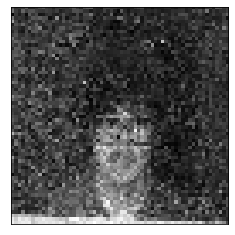

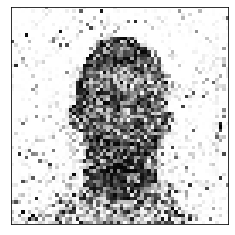

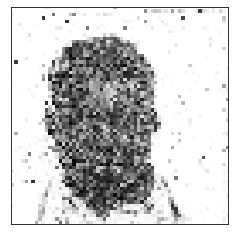

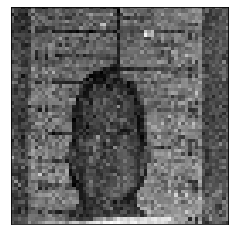

In [54]:
generated_samples = generated_samples.cpu().detach()

for i in range(4):
    fig = plt.figure()
    plt.imshow(generated_samples[i].reshape(image_size, image_size), cmap="gray", figure=fig)
    plt.xticks([])
    plt.yticks([])
    fig.savefig(f"{path}/figure_{i}.png")